Seasonal Trends Test (Profit)
H₀: Profit distributions are equal across all quarters.
H₁: Profit distributions differ across quarters.
Normality (D'Agostino K², Q1, n=3698): Failed (p=0.0000)
Normality (D'Agostino K², Q2, n=2120): Failed (p=0.0000)
Normality (D'Agostino K², Q3, n=2799): Failed (p=0.0000)
Normality (D'Agostino K², Q4, n=1377): Failed (p=0.0000)
Normality test failed for at least one quarter.
Homogeneity of Variances (Levene): Failed
Kruskal-Wallis: Statistic=3.33, p=0.3440
Conclusion: Fail to reject H₀; insufficient evidence to target Q1.
Dunn's test result shape: (4, 4)

No significant quarter pairs (Dunn's Test).
Post-hoc Conclusion: Significant p-values (<0.05) indicate differences in profits.

Ranking of Quarters by Median Profit:
Q4: 8.86
Q3: 8.73
Q1: 8.29
Q2: 8.11


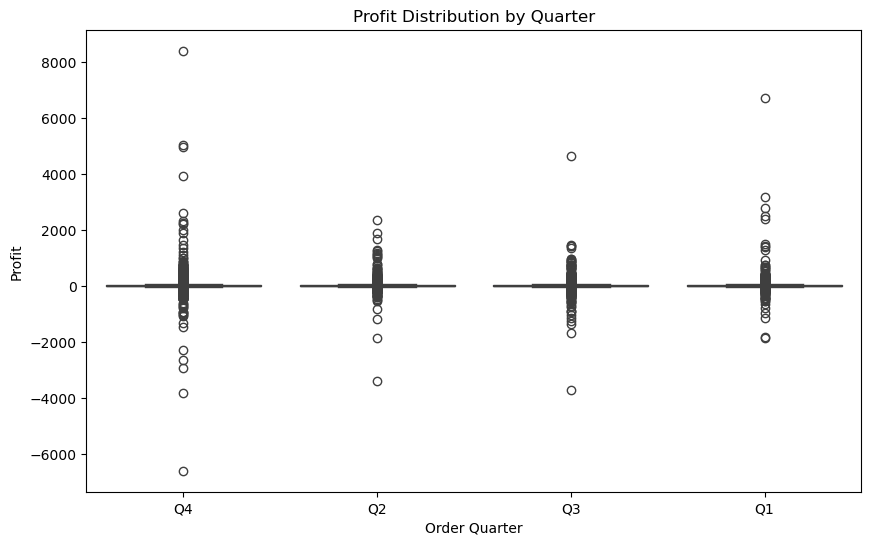

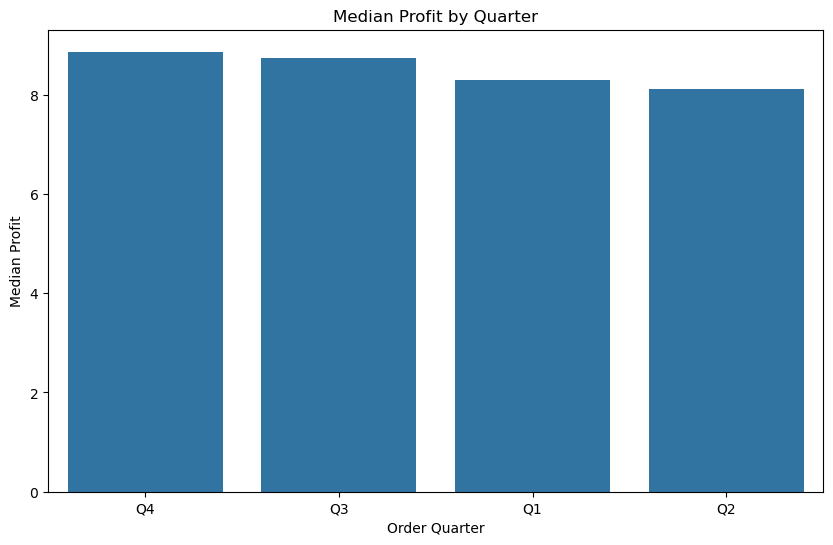

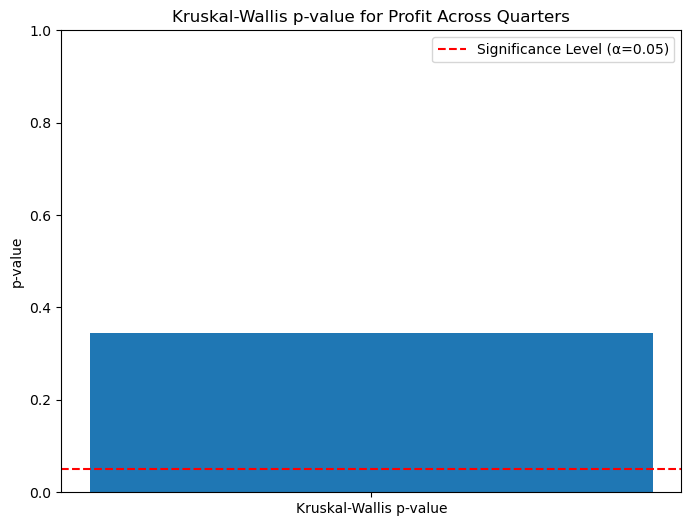

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed
np.random.seed(42)

# Load dataset 
try:
    df = pd.read_csv('SampleSuperstoreClean.csv')
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Order Quarter'] = df['Order Date'].dt.quarter
    df['Order Month'] = df['Order Date'].dt.month
    alpha = 0.05
except FileNotFoundError:
    print("Error: 'SampleSuperstoreClean.csv' not found. Please ensure the file is in the correct directory.")
    raise
except KeyError as e:
    print(f"Error: Missing column {e}. Ensure 'Order Date' and 'Profit' columns exist in the dataset.")
    raise

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality (Q{name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, Q{name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one quarter.")
    
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    if any(len(group) < 3 for group in data_groups):
        print("At least one quarter has insufficient data (<3); defaulting to Kruskal-Wallis.")
        return False
    
    return normality and homogeneity

def summarize_post_hoc(post_hoc, group_names):
    if isinstance(post_hoc, pd.DataFrame):  # Dunn's test
        print("Dunn's test result shape:", post_hoc.shape)
        significant_pairs = post_hoc[post_hoc < alpha].stack()
        if not significant_pairs.empty:
            print("\nSignificant Quarter Pairs (Dunn's Test):")
            for (q1, q2), p in significant_pairs.items():
                print(f"Q{q1} vs Q{q2}: p={p:.4f}")
        else:
            print("\nNo significant quarter pairs (Dunn's Test).")
        return post_hoc
    else:  # Tukey HSD
        df_post_hoc = post_hoc.summary()
        print("Tukey HSD result data:", df_post_hoc.data)
        significant_pairs = [(row[1], row[2], row[6]) for row in df_post_hoc.data if row[6].end() == alpha]
        if significant_pairs:
            print("\nSignificant Quarter Pairs (Tukey HSD):")
            for q1, q2, p in significant_pairs:
                print(f"Q{q1} vs Q{q2}: p={p:.4f}")
        else:
            print("\nNo significant quarter pairs (Tukey HSD).")
        return None

def rank_quarters(df, metric, group_col='Order Quarter'):
    medians = df.groupby(group_col)[metric].median().sort_values(ascending=False)
    print(f"\nRanking of Quarters by Median {metric}:")
    for quarter, median in medians.items():
        print(f"Q{quarter}: {median:.2f}")
    return medians

def plot_median_bar(medians, metric, title, filename, group_col='Order Quarter'):
    plt.figure(figsize=(10, 6))
    # Format index labels as Q1, Q2, etc.
    quarter_labels = [f'Q{int(q)}' for q in medians.index]
    sns.barplot(x=quarter_labels, y=medians.values)
    plt.title(title)
    plt.xlabel(group_col)
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()

def plot_kruskal_pvalue_bar(p_value, title, filename):
    plt.figure(figsize=(8, 6))
    plt.bar(['Kruskal-Wallis p-value'], [p_value])
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (α=0.05)')
    plt.title(title)
    plt.ylabel('p-value')
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig(filename)
    plt.show()

# Seasonal Trends Analysis (Profit)
print("Seasonal Trends Test (Profit)")
print("H₀: Profit distributions are equal across all quarters.")
print("H₁: Profit distributions differ across quarters.")
quarter_profits = [df[df['Order Quarter'] == q]['Profit'].dropna() for q in df['Order Quarter'].unique()]
quarter_names = sorted(df['Order Quarter'].unique())
if not quarter_profits:
    print("Error: No valid profit data for quarters.")
    raise ValueError("Profit data is missing or all quarters have NaN values.")

if check_assumptions(quarter_profits, quarter_names):
    quarter_test = stats.f_oneway(*quarter_profits)
    test_name = "ANOVA"
    post_hoc = pairwise_tukeyhsd(df['Profit'].dropna(), df['Order Quarter'].dropna(), alpha=alpha)
else:
    quarter_test = stats.kruskal(*quarter_profits)
    test_name = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(df.dropna(subset=['Profit', 'Order Quarter']), val_col='Profit', group_col='Order Quarter', p_adjust='bonferroni')
print(f"{test_name}: Statistic={quarter_test.statistic:.2f}, p={quarter_test.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profits differ significantly, supporting targeting Q1 for promotions." if quarter_test.pvalue < alpha else "Fail to reject H₀; insufficient evidence to target Q1.")

# Summarize post-hoc regardless of p-value for debugging
post_hoc_result = summarize_post_hoc(post_hoc, quarter_names)
if post_hoc_result is not None:
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate differences in profits.")
else:
    print("Post-hoc Conclusion: No significant differences or Tukey HSD result.")

# Descriptive Statistics
quarter_medians = rank_quarters(df, 'Profit')

# Visualizations
df['Quarter Label'] = df['Order Quarter'].apply(lambda q: f'Q{int(q)}')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Quarter Label', y='Profit', data=df)
plt.title('Profit Distribution by Quarter')
plt.xlabel('Order Quarter')
plt.ylabel('Profit')
plt.savefig('quarter_profit_boxplot.png')
plt.show()

plot_median_bar(quarter_medians, 'Profit', 'Median Profit by Quarter', 'quarter_profit_median_bar.png')

# Plot Kruskal-Wallis p-value if applicable
if test_name == "Kruskal-Wallis":
    plot_kruskal_pvalue_bar(quarter_test.pvalue, 'Kruskal-Wallis p-value for Profit Across Quarters', 'kruskal_wallis_pvalue_bar.png')

In [15]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)

# Load dataset 
try:
    df = pd.read_csv('SampleSuperstoreClean.csv')
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Order Quarter'] = df['Order Date'].dt.quarter
except FileNotFoundError:
    print("Error: 'SampleSuperstoreClean.csv' not found. Please ensure the file is in the correct directory.")
    raise
except KeyError as e:
    print(f"Error: Missing column {e}. Ensure 'Order Date' and 'Profit' columns exist in the dataset.")
    raise

# Ensure Order Quarter is categorical for dummy encoding
df['Order Quarter'] = df['Order Quarter'].astype('category')

# Encode Order Quarter as dummy variables (Q1 as baseline)
df_encoded = pd.get_dummies(df, columns=['Order Quarter'], prefix='Q', drop_first=True)  # Drops Q_1, keeps Q_2, Q_3, Q_4

# Quantile Regression for Profit (median, q=0.5)
formula_profit = 'Profit ~ Q_2 + Q_3 + Q_4'
quantile_model_profit = smf.quantreg(formula_profit, df_encoded.dropna(subset=['Profit', 'Q_2', 'Q_3', 'Q_4'])).fit(q=0.5)
print("=== Quantile Regression for Profit ===")
print(quantile_model_profit.summary())

# Business-Friendly Interpretations
print("\n=== Business-Friendly Interpretations ===")
print("Profit Model (y = b0 + b1*Q_2 + b2*Q_3 + b3*Q_4):")
for param, value in quantile_model_profit.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit (Q1): {value:.2f}")
    else:
        print(f"Switching to {param.replace('_', '')} changes median Profit by {value:.2f} compared to Q1.")

=== Quantile Regression for Profit ===
                         QuantReg Regression Results                          
Dep. Variable:                 Profit   Pseudo R-squared:            3.238e-05
Model:                       QuantReg   Bandwidth:                       4.652
Method:                 Least Squares   Sparsity:                        37.05
Date:                Sat, 26 Jul 2025   No. Observations:                 9994
Time:                        19:25:29   Df Residuals:                     9990
                                        Df Model:                            3
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.2896      0.499     16.606      0.000       7.311       9.268
Q_2[T.True]    -0.1697      0.641     -0.265      0.791      -1.426       1.087
Q_3[T.True]     0.4434      0.610      0.727      0.467      -0.752       1.639
Q_4[T.Tr

In [16]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_quantile_regression_profit(df, quantile=0.5, min_sample_per_quarter=20, pvalue_threshold=0.05, 
                                  prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                                  max_outlier_percentage=0.05, vif_threshold=5, 
                                  linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Profit using Order Quarter, checks all assumptions, 
    and provides interpretations. Explicitly states whether each assumption is met and 
    addresses violations where possible.
    
    Parameters:
    - df: DataFrame with columns 'Profit', 'Order Date'
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_quarter: Minimum observations per quarter (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - vif_threshold: Threshold for VIF to detect multicollinearity (default: 5)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Set random seed for consistency
    np.random.seed(42)
    
    # Validate input columns
    required_columns = ['Profit', 'Order Date']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Validate numeric columns
    if not pd.api.types.is_numeric_dtype(df['Profit']):
        raise ValueError("Column 'Profit' must be numeric")
    
    # Preprocess: Convert Order Date and create Order Quarter
    df = df.copy()
    try:
        df['Order Date'] = pd.to_datetime(df['Order Date'])
    except Exception as e:
        raise ValueError(f"Failed to convert 'Order Date' to datetime: {e}")
    df['Order Quarter'] = df['Order Date'].dt.quarter.apply(lambda x: f'Q{x}')  # Create Q1, Q2, Q3, Q4
    df['Order Quarter'] = df['Order Quarter'].astype('category')
    
    # Debug: Inspect Profit and Order Quarter
    print("\n=== Debugging Input Data ===")
    print(f"Data type of Profit: {df['Profit'].dtype}")
    print(f"Sample values of Profit: {df['Profit'].head().to_list()}")
    print(f"Number of NaN values in Profit: {df['Profit'].isna().sum()}")
    print(f"Order Quarter Distribution:\n{df['Order Quarter'].value_counts(dropna=False)}")
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Profit', 'Order Quarter']
    missing_values = df[required_columns].isna().sum()
    print("\n=== Assumption Check 1: Data Availability and No Missing Values ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with median for Profit, mode for Order Quarter")
        df['Profit'] = df['Profit'].fillna(df['Profit'].median())
        df['Order Quarter'] = df['Order Quarter'].fillna(df['Order Quarter'].mode()[0])
        print("Missing values after imputation:\n", df[required_columns].isna().sum())
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    quarter_counts = df['Order Quarter'].value_counts()
    total_sample = len(df)
    min_total_sample = 4 * min_sample_per_quarter  # 4 quarters
    print("\n=== Assumption Check 2: Sufficient Sample Size ===")
    print(f"Total sample size: {total_sample}")
    print(f"Order Quarter counts:\n{quarter_counts}")
    if all(quarter_counts >= min_sample_per_quarter) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All quarters have >= {min_sample_per_quarter} observations, total sample >= {min_total_sample})")
    else:
        assumption_status["Sufficient Sample Size"] = False
        print(f"Status: NOT MET (Some quarters have < {min_sample_per_quarter} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or combine quarters")
    
    # Assumption 3: No Extreme Outliers
    profit_outliers = df[np.abs(df['Profit'] - df['Profit'].mean()) > 3 * df['Profit'].std()]
    outlier_percentage = len(profit_outliers) / total_sample
    print("\n=== Assumption Check 3: No Extreme Outliers ===")
    print(f"Number of Profit outliers (beyond 3 std): {len(profit_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        assumption_status["No Extreme Outliers"] = False
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Encode Order Quarter as dummy variables (Q1 as baseline)
    df_encoded = pd.get_dummies(df, columns=['Order Quarter'], prefix='', prefix_sep='')  # Drops Q1
    quarter_cols = ['Q2', 'Q3', 'Q4']
    missing_cols = [col for col in quarter_cols if col not in df_encoded.columns]
    if missing_cols:
        raise ValueError(f"Missing dummy columns: {missing_cols}. Check Order Quarter encoding.")
    
    # Assumption 6: No Multicollinearity
    X = df_encoded[quarter_cols].astype(float)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = quarter_cols
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== Assumption Check 6: No Multicollinearity ===")
    print(vif_data)
    if all(vif_data['VIF'] < vif_threshold):
        assumption_status["No Multicollinearity"] = True
        print(f"Status: MET (All VIF values < {vif_threshold})")
    else:
        assumption_status["No Multicollinearity"] = False
        print(f"Status: NOT MET (Some VIF values >= {vif_threshold})")
        print("Recommendation: Remove or combine correlated quarter variables")
    
    # Quantile Regression for Profit (initial fit)
    formula_profit = 'Profit ~ Q2 + Q3 + Q4'
    df_model = df_encoded.dropna(subset=['Profit'] + quarter_cols)
    try:
        quantile_model_profit = smf.quantreg(formula_profit, df_model).fit(q=quantile)
    except Exception as e:
        print(f"Error fitting quantile regression: {e}")
        raise ValueError("Failed to fit quantile regression model. Ensure Profit is numeric and quarter variables are valid.")
    
    # Assumption 4: Correct Model Specification
    profit_pvalues = quantile_model_profit.pvalues
    profit_prsquared = quantile_model_profit.prsquared
    print("\n=== Assumption Check 4: Correct Model Specification ===")
    print("Profit Model p-values:\n", profit_pvalues)
    print(f"Profit Model Pseudo R-squared: {profit_prsquared:.4f}")
    if all(profit_pvalues <= pvalue_threshold) and profit_prsquared >= prsquared_threshold:
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        assumption_status["Correct Model Specification"] = False
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., category, discount) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    profit_residuals = quantile_model_profit.resid
    dw_profit = durbin_watson(profit_residuals)
    print("\n=== Assumption Check 5: Independence of Observations ===")
    print(f"Profit Model Durbin-Watson statistic: {dw_profit:.2f}")
    if dw_lower <= dw_profit <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistic between {dw_lower} and {dw_upper})")
    else:
        assumption_status["Independence of Observations"] = False
        print(f"Status: NOT MET (Durbin-Watson statistic outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    profit_model_q25 = smf.quantreg(formula_profit, df_model).fit(q=0.25)
    profit_model_q75 = smf.quantreg(formula_profit, df_model).fit(q=0.75)
    profit_pvalues_q25 = profit_model_q25.pvalues
    profit_pvalues_q75 = profit_model_q75.pvalues
    print("\n=== Assumption Check 7: Linearity at Quantile ===")
    print("Profit Model p-values at q=0.25:\n", profit_pvalues_q25)
    print("Profit Model p-values at q=0.75:\n", profit_pvalues_q75)
    if all(profit_pvalues_q25 <= linearity_pvalue_threshold) and all(profit_pvalues_q75 <= linearity_pvalue_threshold):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        assumption_status["Linearity at Quantile"] = False
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms or additional predictors (e.g., category)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    profit_pred_q25 = profit_model_q25.predict(df_model)
    profit_pred_q50 = quantile_model_profit.predict(df_model)
    profit_pred_q75 = profit_model_q75.predict(df_model)
    profit_monotonic = (profit_pred_q25 <= profit_pred_q50).all() and (profit_pred_q50 <= profit_pred_q75).all()
    print("\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ===")
    print(f"Profit predictions monotonic: {profit_monotonic}")
    if profit_monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print("Status: MET (Predicted quantiles are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        assumption_status["Monotonicity of Conditional Quantiles"] = False
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print("\n=== Assumption Check 9: Robust Confidence Intervals ===")
    print("Action: Refitting model with robust standard errors for reliable inference")
    quantile_model_profit = smf.quantreg(formula_profit, df_model).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Model refitted with robust standard errors)")
    
    # Model Summary
    print("\n=== Quantile Regression for Profit ===")
    print(quantile_model_profit.summary())
    
    # Business-Friendly Interpretations
    print("\n=== Business-Friendly Interpretations ===")
    print("Profit Model (y = b0 + b1*Q2 + b2*Q3 + b3*Q4):")
    for param, value in quantile_model_profit.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit (Q1): {value:.2f}")
        else:
            print(f"Switching to {param} changes median Profit by {value:.2f} compared to Q1.")
    
    # Summary of Assumption Status
    print("\n=== Summary of Assumption Checks ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Main execution
if __name__ == "__main__":
    # Read data
    try:
        df = pd.read_csv('SampleSuperstoreClean.csv')
    except FileNotFoundError:
        raise FileNotFoundError("SampleSuperstoreClean.csv not found. Please provide the correct file path.")
    
    # Convert Profit to numeric
    df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
    
    # Run the quantile regression with assumption checks
    run_quantile_regression_profit(df)


=== Debugging Input Data ===
Data type of Profit: float64
Sample values of Profit: [41.9136, 219.582, 6.8714, -383.031, 2.5164]
Number of NaN values in Profit: 0
Order Quarter Distribution:
Order Quarter
Q4    3698
Q3    2799
Q2    2120
Q1    1377
Name: count, dtype: int64

=== Assumption Check 1: Data Availability and No Missing Values ===
Missing values:
Profit           0
Order Quarter    0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size ===
Total sample size: 9994
Order Quarter counts:
Order Quarter
Q4    3698
Q3    2799
Q2    2120
Q1    1377
Name: count, dtype: int64
Status: MET (All quarters have >= 20 observations, total sample >= 80)

=== Assumption Check 3: No Extreme Outliers ===
Number of Profit outliers (beyond 3 std): 107
Percentage of outliers: 1.07%
Status: MET (Outlier percentage <= 5.0%)

=== Assumption Check 6: No Multicollinearity ===
  Variable  VIF
0       Q2  1.0
1       Q3  1.0
2       Q4  1.0
Status: MET (Al